In [8]:
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Embedding, LSTM, Flatten, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import pandas as pd
import os
import nltk
import re
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('C:/Users/USER/TA/Refrensi/buku.csv', encoding='ISO-8859-1', sep='delimiter', engine='python')
df.head(30)

,judul;
0,Keanggotaan Investasi Reseller Bukukita;
1,Keanggotaan Investasi Dropship Bukukita;
2,Komik Dari Twit-nya Raditya Dika;
3,Rangkuman Tips Beriklan Selama 9 Tahun;
4,PROPERTI KOMODO ;
5,Panduan Menulis Siswa Tingkat Dasar;
6,Buku Saku Kumpulan Rumus Matematika SMA IPA;
7,Cahaya Di Penjuru HATI;
8,Catatan Ayahasi Ditambah-tambahin;
9,Al-Akram;


In [4]:
print("Number of records: ", df.shape[0])

Number of records:  5618


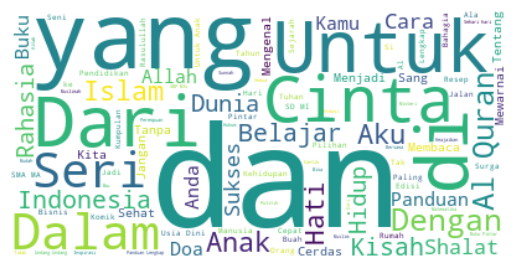

In [10]:
# menggabungkan semua teks dari kolom yang ingin digunakan dalam satu string
text = ' '.join(df['judul;'])

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=100, background_color="white").generate(str(text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
# Converting to lowercase
df['judul;'] = df['judul;'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['judul;'].head()

0    keanggotaan investasi reseller bukukita;
1    keanggotaan investasi dropship bukukita;
2           komik dari twit-nya raditya dika;
3     rangkuman tips beriklan selama 9 tahun;
4                           properti komodo ;
Name: judul;, dtype: object

In [6]:
# Removing symbols
df['judul;'] = df['judul;'].apply(lambda x:re.sub('[!@#$:).;,?&]', "", x.lower()))
df['judul;'].head()

0    keanggotaan investasi reseller bukukita
1    keanggotaan investasi dropship bukukita
2           komik dari twit-nya raditya dika
3     rangkuman tips beriklan selama 9 tahun
4                           properti komodo 
Name: judul;, dtype: object

In [7]:
tokenizer = Tokenizer(oov_token=None) # For those words which are not found in word_index
tokenizer.fit_on_texts(df['judul;'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)

Total number of words:  6887


In [8]:
input_sequences = []
for line in df['judul;']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  25389


In [9]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 2001,  581, 3025])

In [10]:
# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token6pre4.pkl', 'wb'))
# saving the padding for predict function
pickle.dump(max_sequence_len, open('padding6pre4.pkl', 'wb'))

In [11]:
# create features and label
x, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = to_categorical(labels, num_classes=total_words)

In [12]:
print(x[5])
print(labels[5])
print(y[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0 2001
  581 3026]
2002
0.0


In [13]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(total_words, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 10)            68870     
                                                                 
 bidirectional (Bidirectiona  (None, 512)              546816    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6887)              3533031   
                                                                 
Total params: 4,148,717
Trainable params: 4,148,717
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Untuk melakukan penghentian otomatis pelatihan
from keras.callbacks import TensorBoard, EarlyStopping
callback = EarlyStopping(monitor = 'loss', patience = 1, mode = 'min', restore_best_weights = True)

In [16]:
# adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, y, epochs=200, verbose=1)
#print model.summary()
print(model)

Epoch 1/200
794/794 [==============================] - 61s 73ms/step - loss: 7.8454 - accuracy: 0.0406
Epoch 2/200
794/794 [==============================] - 55s 69ms/step - loss: 7.2545 - accuracy: 0.0439
Epoch 3/200
794/794 [==============================] - 52s 65ms/step - loss: 6.8426 - accuracy: 0.0549
Epoch 4/200
794/794 [==============================] - 56s 71ms/step - loss: 6.3681 - accuracy: 0.0750
Epoch 5/200
794/794 [==============================] - 50s 63ms/step - loss: 5.8299 - accuracy: 0.0994
Epoch 6/200
794/794 [==============================] - 47s 60ms/step - loss: 5.2457 - accuracy: 0.1269
Epoch 7/200
794/794 [==============================] - 45s 57ms/step - loss: 4.6638 - accuracy: 0.1639
Epoch 8/200
794/794 [==============================] - 46s 58ms/step - loss: 4.1177 - accuracy: 0.2220
Epoch 9/200
794/794 [==============================] - 45s 57ms/step - loss: 3.6524 - accuracy: 0.2827
Epoch 10/200
794/794 [==============================] - 46s 58ms/step - l

794/794 [==============================] - 47s 59ms/step - loss: 0.5206 - accuracy: 0.8129
Epoch 158/200
794/794 [==============================] - 47s 59ms/step - loss: 0.5201 - accuracy: 0.8111
Epoch 159/200
794/794 [==============================] - 48s 60ms/step - loss: 0.5205 - accuracy: 0.8104
Epoch 160/200
794/794 [==============================] - 48s 60ms/step - loss: 0.5218 - accuracy: 0.8100
Epoch 161/200
794/794 [==============================] - 49s 61ms/step - loss: 0.5231 - accuracy: 0.8096
Epoch 162/200
794/794 [==============================] - 46s 58ms/step - loss: 0.5138 - accuracy: 0.8135
Epoch 163/200
794/794 [==============================] - 47s 59ms/step - loss: 0.5120 - accuracy: 0.8133
Epoch 164/200
794/794 [==============================] - 45s 57ms/step - loss: 0.5170 - accuracy: 0.8105
Epoch 165/200
794/794 [==============================] - 48s 60ms/step - loss: 0.5216 - accuracy: 0.8117
Epoch 166/200
794/794 [==============================] - 46s 58ms/ste

In [17]:
# Membuat fungsi untuk menampilkan plot hasil akurasi
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 5))
  plt.plot(data,'darkblue', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

C:\Users\USER\AppData\Local\Temp\ipykernel_10192\1061866947.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


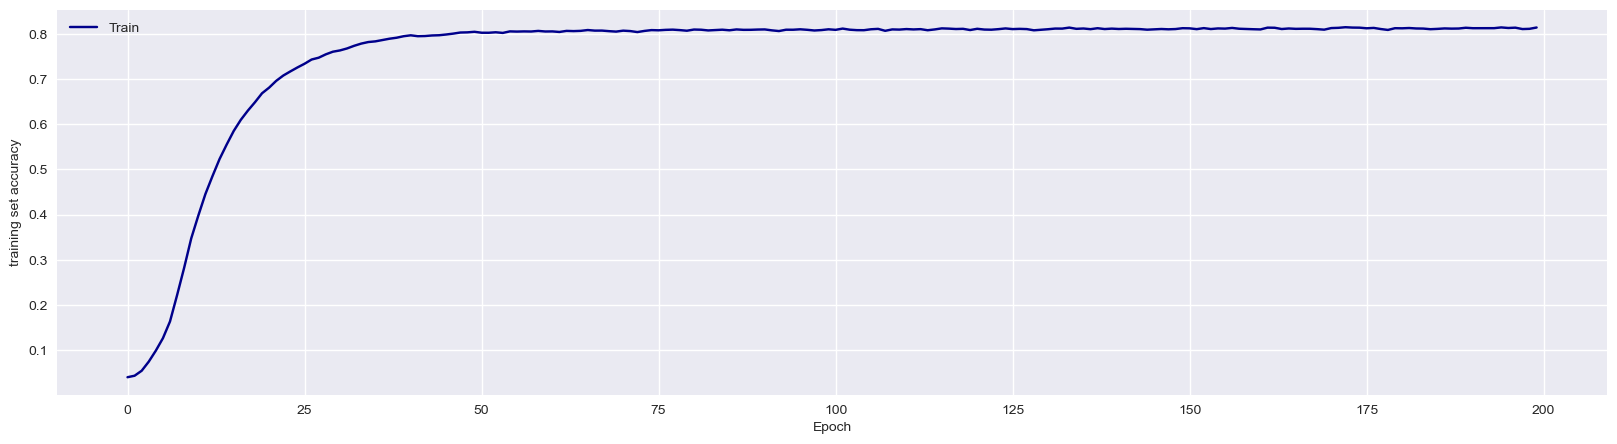

In [18]:
# Menampilkan plot akurasi
draw_plot(history.history['accuracy'],'training set accuracy' )

C:\Users\USER\AppData\Local\Temp\ipykernel_10192\1061866947.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


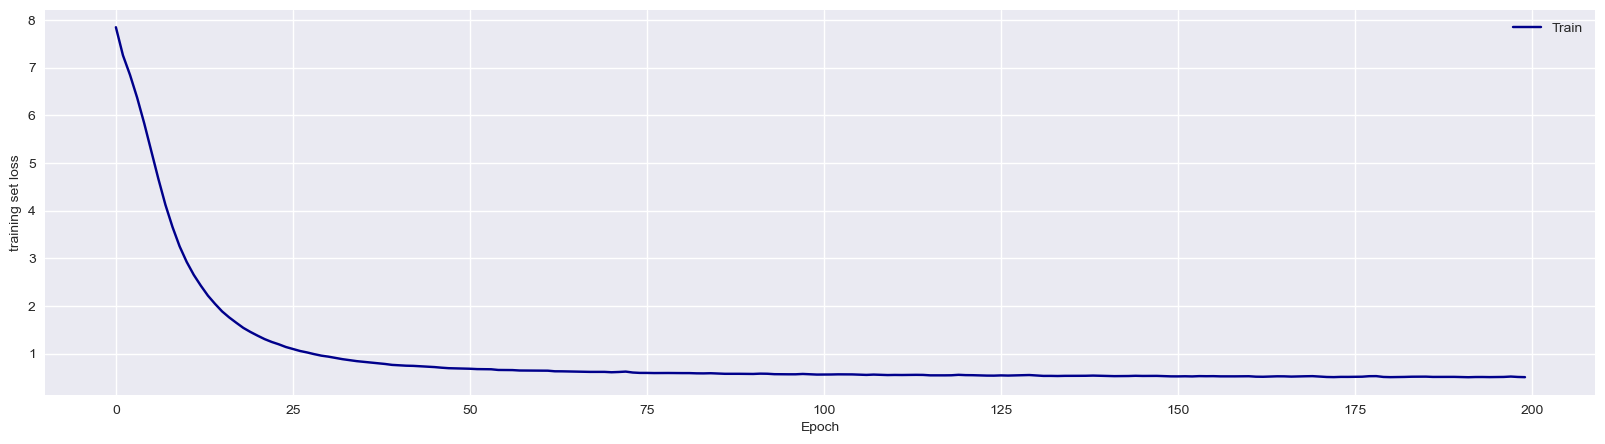

In [19]:
# Menampilkan plot loss
draw_plot(history.history['loss'],'training set loss' )

In [20]:
# Menyimpan model
model.save('model6pre4.h5', history)

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle
  
# load the model
model = load_model('model6pre4.h5')

# load the tokenizer
tokenizer = pickle.load(open('token6pre4.pkl', 'rb'))

# load the tokenizer
max_sequence_len = pickle.load(open('padding6pre4.pkl', 'rb'))

while(True):
    seed_text = input("Enter your line: ")
    
    if seed_text == "end":
        print("Execution completed.....")
        break
    
    else:
        try:
            next_words = 4

            for _ in range(next_words):
                token_list = tokenizer.texts_to_sequences([seed_text])[0]
                token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
                predicted = np.argmax(model.predict(token_list))
                output_word = ""
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        output_word = word
                        break
                seed_text += " " + output_word
            print(seed_text)
            
        except Exception as e:
            print("Error occurred: ",e)
            continue

Enter your line: end
Execution completed.....
